# Description

Notebook for simulation of data-driven exclusion procedure for results in Section 4.4 and Figure 3.

# Imports

In [18]:
%load_ext autoreload
%autoreload

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import sys
import warnings

from econml.grf import CausalForest
from linearmodels.iv import IV2SLS
from sklearn.model_selection import StratifiedKFold

# user imports
sys.path.append("../")

from utils.pwr import rdd_power
from utils.sim import generate_IV_comply_indicator
from utils.clf import iv_neff, ThresholdCV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulation  functions

In [40]:
def fit_predict_compliance(fit_df, pred_df, feat_cols, tau, seed=0, clf=None):
    """
    Fits a compliance model on fit_df and returns the predicted compliance scores, 
    as well as predicted threshold. Specifically uses the cross-folding neff heuristic.
    
    Args:
        fit_df (pd.DataFrame): the dataframe to fit on
        pred_df (pd.DataFrame): the dataframe to generate prediction
        feat_cols (list): the list of feature columns to consider
        tau (float): the target treatment effect
        clf (model): an EconML CATE classifier, defaults to CausalForest if None provided
    
    Returns:
        exclusion_threshold, acc, selected_df
    """
    
    
    fit_df = fit_df.copy()
    pred_df = pred_df.copy()
    
    X = fit_df[feat_cols]
    T = fit_df['Z']
    Y = fit_df['T']
    
    # fit on fit_df data
    if clf is None:
        clf = CausalForest(random_state=seed)
    
    clf.fit(y=Y, # need to switch back to capital "Y" for DML estimator
            T=T,
            X=X)
    
    # predict on fit and pred_df data
    fit_df['pred_comply'] = clf.predict(X)
    pred_df['pred_comply'] = clf.predict(pred_df[feat_cols])
    acc = np.nan
    
    
    
    # use neff cross-validated scoring target here
    threshold_clf = ThresholdCV()
    exclusion_threshold = threshold_clf.get_best_threshold(fit_df, feat_cols)
            
    sel_df = pred_df[pred_df['pred_comply'] > exclusion_threshold]

    return exclusion_threshold, acc, sel_df


def populate_iv_results(df_dict, formula, data_df, tau, data_sample, acc=np.nan, threshold=np.nan):
    """
    Runs the 2SLS estimator and populates result_dict.
    
    Args:
        df_dict (dict)
        formulat (str): the patsy regression formula to use
        data_df (pd.DataFrame): the dataframe to run over
        tau (float): target treatment effect for power calculations
        data_sample (str): the name of the data sample
        acc (float): the test accuracy of the prediction, if applicable
        threshold (float): the complier threshold cutoff, if applicable
    
    Returns:
        None, but mutates result_dict
    """
    #print("data_df shape:{}".format(data_df.shape[0]))
    iv_model = IV2SLS.from_formula(formula, data_df)
    iv_results = iv_model.fit(cov_type='robust')
    df_dict['tau_hat_{}'.format(data_sample)].append(iv_results.params['T'])
    df_dict['std_err_{}'.format(data_sample)].append(iv_results.std_errors['T'])
    df_dict['pwr_{}'.format(data_sample)].append(rdd_power(tau,iv_results.std_errors['T']**2))
    df_dict['n_incl_{}'.format(data_sample)].append(data_df.shape[0])
    df_dict['test_acc_{}'.format(data_sample)].append(acc)
    df_dict['threshold_{}'.format(data_sample)].append(threshold)
    

def simulate_optimal_exclusion(n_trials, clf=None, **kwargs):
    """
    Simulates optimal exclusion procedure with K=2 cross-fitting/sample splitting.
    
    Args:
        n_trials (int): number of trials to run
        clf (econml.DML): the compliance estimator to use
        kwargs: keyword arguments for gen_iv_with_comply_status
    
    Returns:
        df: a DataFrame containing:
            - trial
            - treatment effect estimate, std error, calculated power for:
                - full data simple 2SLS
                - full data 2SLS with covariates
                - s1 exclusion estimates
                - s2 exclusion estimates
            - s1, s2 number of included samples
            - s1, s2 compliance "test set" prediction accuracy
    """    
    #print("true treatment effect: {}".format(kwargs['tau']))
    # initialize data dictionary    
    data_samples = ['full_simple', 'full_covar', 's1_simple', 's2_simple', 's1_s2_simple']
    vals = ['tau_hat', 'std_err', 'pwr', 'n_incl', 'test_acc', 'threshold']
    df_dict = { val + "_" + data: [] for val in vals for data in data_samples}
    df_dict['trial'] = []
    
    simple_formula = 'Y ~ 1 + [T ~ Z]'
    
    for trial in tqdm(range(n_trials)):
        fuzzy_df = generate_IV_comply_indicator(seed=trial, **kwargs)
        feat_cols = fuzzy_df.columns[fuzzy_df.columns.str.startswith("feat")].tolist()
        extended_formula = 'Y ~ 1 + {} + [T ~ Z]'.format(' + '.join(feat_cols))

        # simple model with full data
        populate_iv_results(df_dict, simple_formula, fuzzy_df, kwargs['tau'], 'full_simple')

        # covariate model with full data
        populate_iv_results(df_dict, extended_formula, fuzzy_df, kwargs['tau'], 'full_covar')
        
        # split sample
        np.random.seed(trial)
        
        kfold = StratifiedKFold(n_splits=2,
             shuffle=True, random_state=trial)

        indices = []

        for train_idx, test_idx in kfold.split(fuzzy_df, y=fuzzy_df['T']):
            indices.append(test_idx)
    

        fit_df = fuzzy_df.iloc[indices[0]].copy()
        s2_df = fuzzy_df.iloc[indices[1]].copy()

        # fit on first half
        s1_threshold, s1_acc, s1_sel_df = fit_predict_compliance(fit_df, s2_df, feat_cols, 
                                                                 seed=trial,
                                                                 tau=kwargs['tau'], clf=clf)

        populate_iv_results(df_dict, simple_formula, s1_sel_df, kwargs['tau'], 's1_simple',
                            threshold=s1_threshold, acc=s1_acc)

        # fit on second half
        s2_threshold, s2_acc, s2_sel_df = fit_predict_compliance(s2_df, fit_df, feat_cols, 
                                                                 seed=trial,
                                                                 tau=kwargs['tau'], clf=clf)

        populate_iv_results(df_dict, simple_formula, s2_sel_df, kwargs['tau'], 's2_simple',
                            threshold=s2_threshold, acc=s2_acc)

        
        # fit on union of excluded samples
        populate_iv_results(df_dict, simple_formula, s1_sel_df.append(s2_sel_df), kwargs['tau'], 's1_s2_simple')

        df_dict['trial'].append(trial)
        #print("trial {}".format(trial))

    return pd.DataFrame.from_dict(df_dict)

In [12]:
def run_full_simulation(n_trials, prop_complys, sim_dict, out_name):
    """
    Runs end-to-end the simulation for Figure 3.
    """
    for prop_comply in prop_complys:
        # equal proportion of never takers and always takers
        p_at = (1 - prop_comply) / 2
        p_nt = (1 - prop_comply) / 2
        sim_dict['prop_at'] = p_at
        sim_dict['prop_nt'] = p_nt

        result_df = simulate_optimal_exclusion(n_trials, **sim_dict)

        result_df['data_driven_tau'] = (result_df['tau_hat_s1_simple'] + result_df['tau_hat_s2_simple']) / 2
        
        # from law of total variance
        result_df['data_driven_var'] = ((result_df['std_err_s1_simple'] ** 2) + (result_df['std_err_s2_simple'] ** 2) + \
                                     (result_df['tau_hat_s1_simple'] - result_df['data_driven_tau'])**2 + \
                                     (result_df['tau_hat_s2_simple'] - result_df['data_driven_tau'])**2) / 2

        result_df['data_driven_std'] = np.sqrt(result_df['data_driven_var'])


        result_df['data_driven_pwr'] = result_df['data_driven_var'].apply(lambda x: rdd_power(tau, var=x))
        result_df['data_driven_n_incl'] = result_df['n_incl_s1_simple'] + result_df['n_incl_s2_simple']

        name = "../results/{}_p_comply_{}.df".format(out_name, prop_comply)
        result_df.to_pickle(name)

In [13]:
def plot_tau_pwr(data_name, tau, p_complys):
    # load data
    name_prefix = "../results/{}_p_comply".format(data_name) + "_{}.df"
    all_df = pd.DataFrame()
    x_var = 'Proportion compliers'

    for p_comply in p_complys:
        gap_df = pd.read_pickle(name_prefix.format(p_comply))
        gap_df[x_var] = p_comply
        
        all_df = all_df.append(gap_df)

    tau_hats = pd.melt(all_df, id_vars=[x_var], value_vars = ['tau_hat_full_simple', 'tau_hat_full_covar', 
                                                      'tau_hat_s1_s2_simple'])
    pwrs = pd.melt(all_df, id_vars=[x_var], value_vars = ['pwr_full_simple', 'pwr_full_covar', 
                                                  'pwr_s1_s2_simple'])
    std_errs = pd.melt(all_df, id_vars=[x_var], value_vars = ['std_err_full_simple', 'std_err_full_covar', 
                                                      'std_err_s1_s2_simple'])

    fig, (ax1, ax2) = plt.subplots(1,2, dpi=300, figsize=(12,6))

    sns.barplot(data=tau_hats, hue="variable", x=x_var, y="value", ax=ax1)
    ax1.axhline(y=tau, label="true treatment effect", ls='--', color="black", alpha=0.5)
    ax1.set_ylabel("est. treatment effect (95% CI)")
    ax1.set_ylim(0,0.5)


    handles, labels = ax1.get_legend_handles_labels()
    new_labels = ['true treatment effect', 'TSLS', 'TSLS with covariates', 'data-driven TSLS']
    ax1.legend(handles, new_labels)

    sns.barplot(data=pwrs, hue="variable", x=x_var, y="value", ax=ax2)#, estimator=median)
    ax2.set_ylabel("estimated power (95% CI)")
    ax2.get_legend().set_visible(False)

# Run simulations

In [23]:
tau = 0.25
n_samples = 2000
n_trials = 500
prop_complys = [0.2, 0.4, 0.6]

## Strong compliance prediction simulation

In [24]:
# strong_sim_dict = dict(
#         tau = tau, # true treatment effect
#         n_samples = n_samples,
#         use_covars = True,
#         # tunes how much the covariates influence compliance
#         regression_dict = dict(n_informative=5, 
#                                noise=0, 
#                                n_features=5)
# )

# strong_out_name = "strong_comply"

In [ ]:
# %%time
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     run_full_simulation(n_trials, prop_complys, 
#                         strong_sim_dict, 
#                         strong_out_name)

## weak compliance prediction simulation

In [26]:
# weak_sim_dict = dict(
#         tau = tau, # true treatment effect
#         n_samples = n_samples,
#         use_covars = True,
#         # tunes how much the covariates influence compliance
#         regression_dict = dict(n_informative=5, 
#                                noise=75, 
#                                n_features=5)
# )

# weak_out_name = "weak_comply"

In [ ]:
# %%time

# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     run_full_simulation(n_trials, prop_complys, 
#                         weak_sim_dict, 
#                         weak_out_name)

## noise compliance prediction simulation

In [ ]:
# noise_sim_dict = dict(
#         tau = tau, # true treatment effect
#         n_samples = n_samples,
#         use_covars = True,
#         # tunes how much the covariates influence compliance
#         regression_dict = dict(n_informative=0, 
#                                noise=75, 
#                                n_features=5)
# )

# noise_out_name = "noise_comply"

In [ ]:
# %%time

# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     run_full_simulation(n_trials, prop_complys, 
#                         noise_sim_dict, 
#                         noise_out_name)

# Plotting

In [49]:
tau = 0.25
n_samples = 2000
n_trials = 500
prop_complys = [0.2, 0.4, 0.6]

In [50]:
result_dict = {}
for data_name in ['strong_comply', 'weak_comply', 'noise_comply']:
    # load data
    name_prefix = "../results/{}_p_comply".format(data_name) + "_{}.df"
    all_df = pd.DataFrame()
    x_var = 'Proportion compliers'

    for p_comply in prop_complys:
        gap_df = pd.read_pickle(name_prefix.format(p_comply))
        gap_df[x_var] = p_comply
        
        all_df = all_df.append(gap_df)
    
    result_dict[data_name] = all_df

## Combined six plots

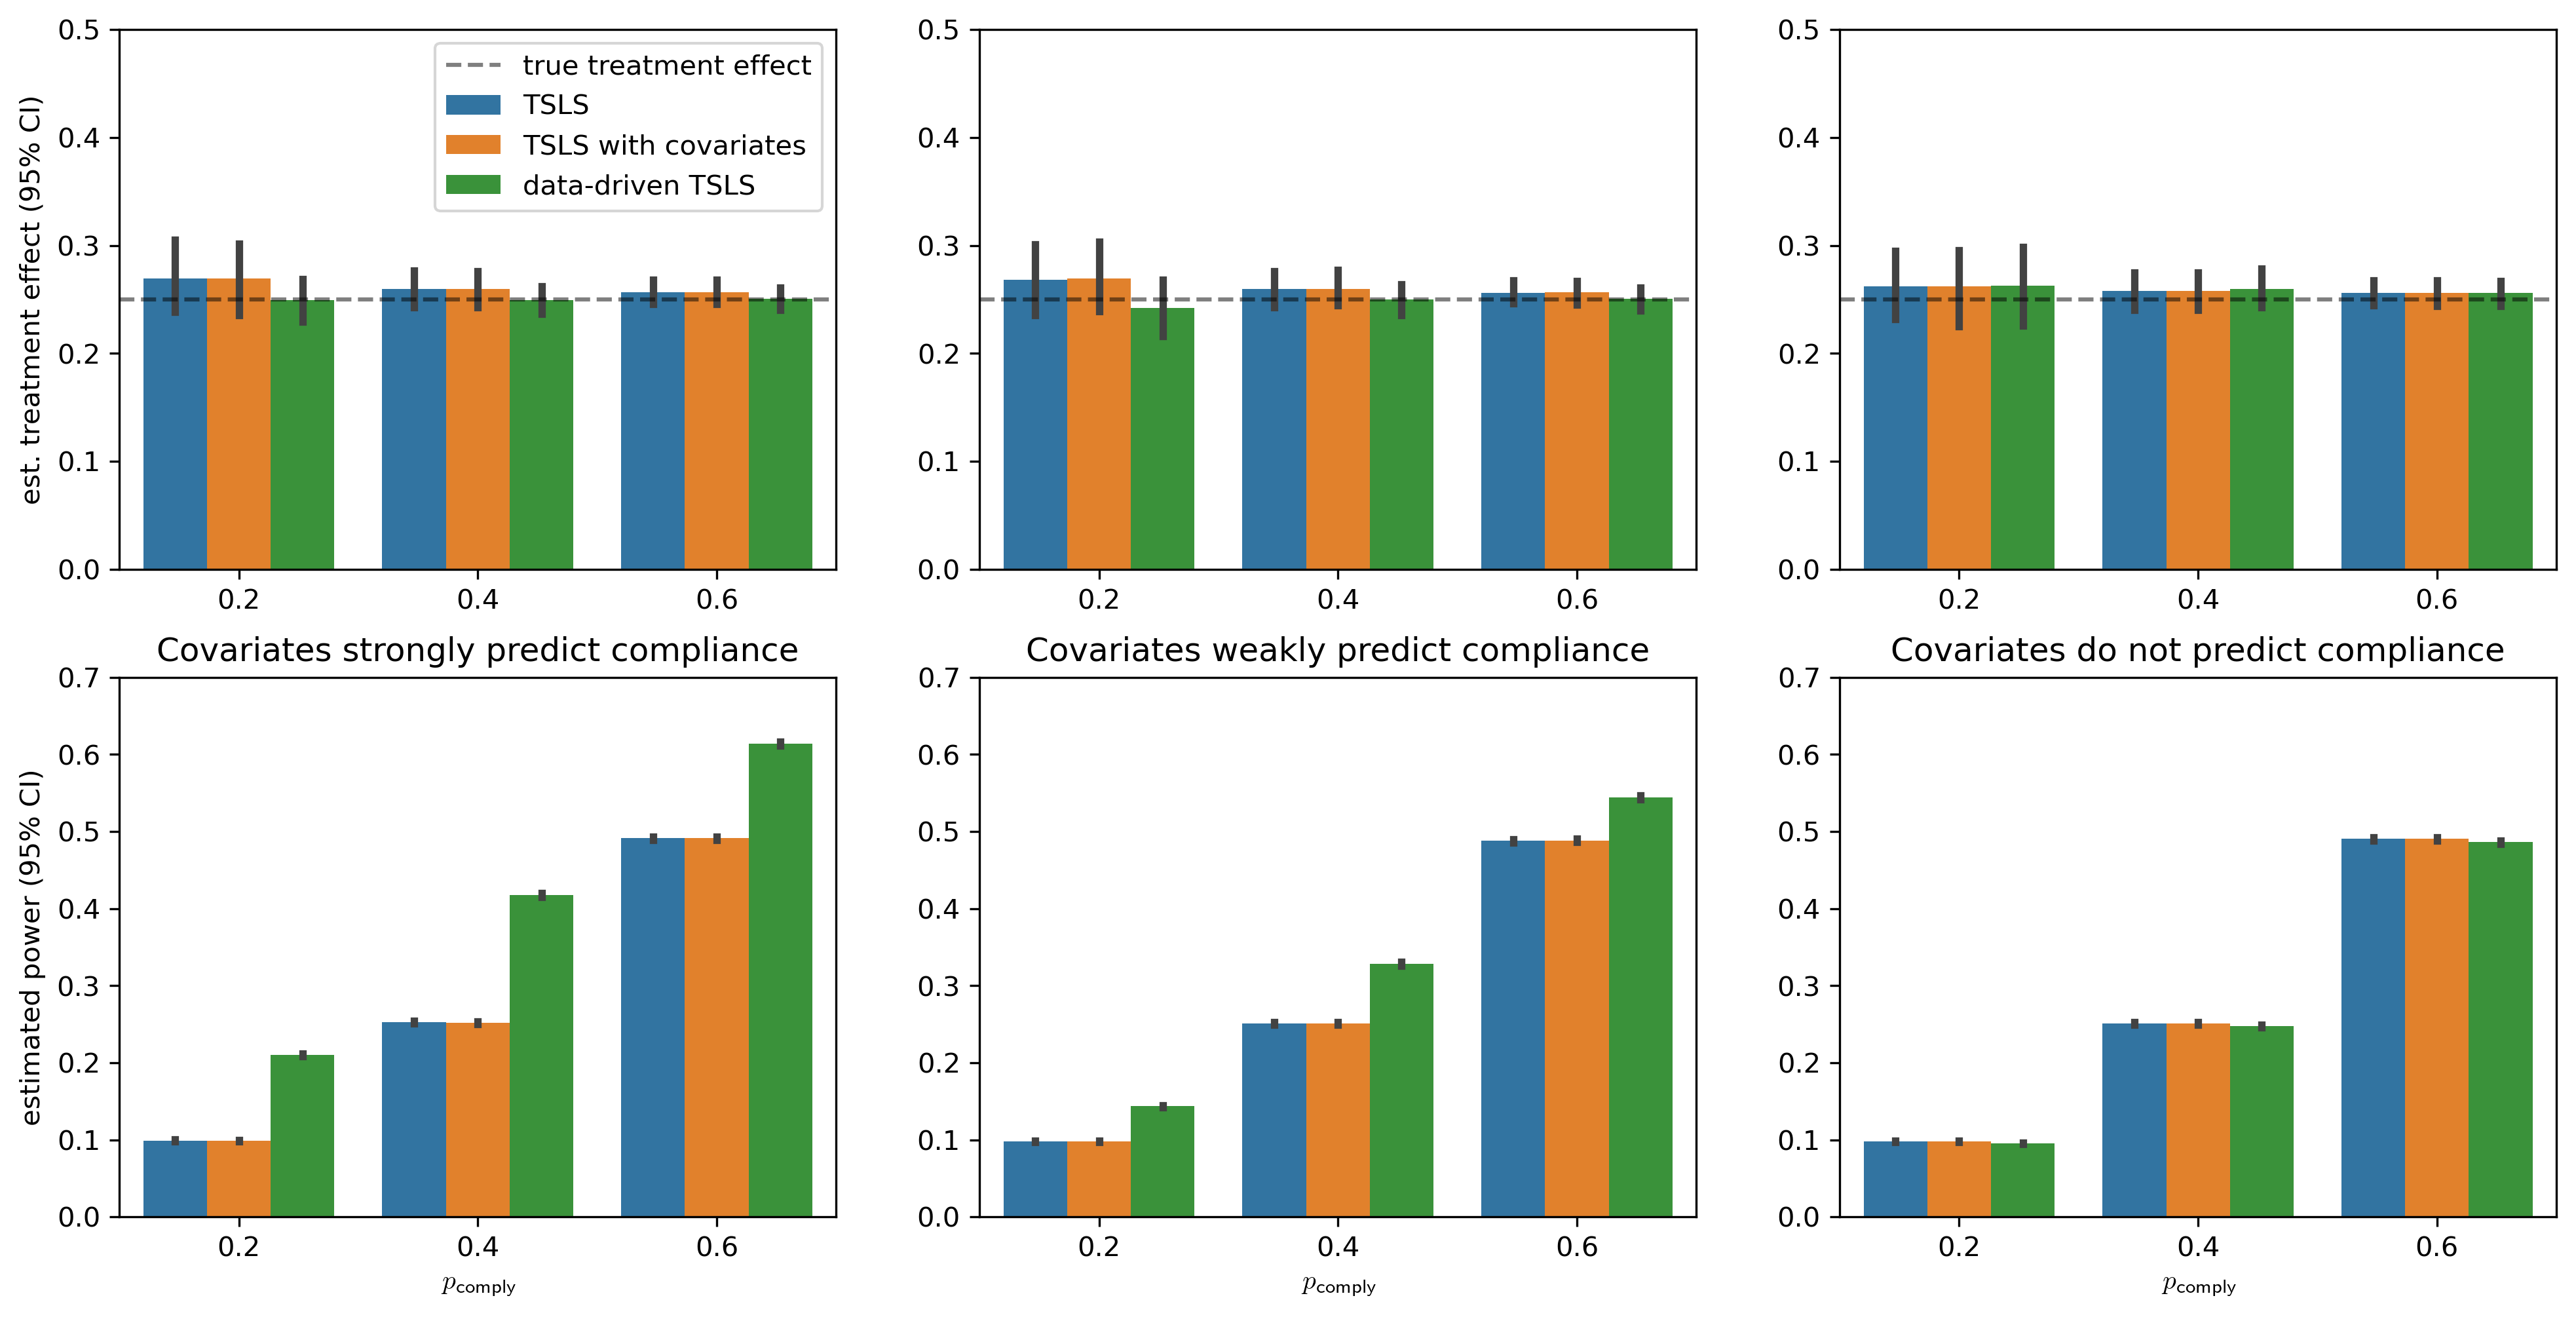

In [51]:
fig, (tau_axes, pwr_axes) = plt.subplots(2,3, figsize=(16,8), dpi=300)
x_var = 'Proportion compliers'

plt.rcParams.update({
    "text.usetex": False,
    'text.latex.preamble' : [r'\usepackage{amsmath}']
})

for idx, data_name in enumerate(['strong_comply', 'weak_comply', 'noise_comply']):
    
    cur_df = result_dict[data_name]
    
    tau_hats = pd.melt(cur_df, id_vars=[x_var], value_vars = ['tau_hat_full_simple', 'tau_hat_full_covar', 
                                                              'tau_hat_s1_s2_simple'])
    pwrs = pd.melt(cur_df, id_vars=[x_var], value_vars = ['pwr_full_simple', 'pwr_full_covar', 
                                                          'pwr_s1_s2_simple'])

    # tau plotting
    sns.barplot(data=tau_hats, hue="variable", x=x_var, y="value", ax=tau_axes[idx])
    tau_axes[idx].axhline(y=tau, label="true treatment effect", ls='--', color="black", alpha=0.5)
    tau_axes[idx].set_ylim(0,0.5)
    tau_axes[idx].set_ylabel("")
    tau_axes[idx].set_xlabel("")
    if idx > 0:
        tau_axes[idx].get_legend().remove()

    
    # pwr plotting
    sns.barplot(data=pwrs, hue="variable", x=x_var, y="value", ax=pwr_axes[idx])
    pwr_axes[idx].set_ylim(0,0.7)
    pwr_axes[idx].set_ylabel("")
    pwr_axes[idx].set_xlabel("")
    pwr_axes[idx].get_legend().remove()
    
tau_axes[0].set_ylabel("est. treatment effect (95% CI)")
pwr_axes[0].set_ylabel("estimated power (95% CI)")

pwr_axes[0].set_title("Covariates strongly predict compliance")
pwr_axes[1].set_title("Covariates weakly predict compliance")
pwr_axes[2].set_title("Covariates do not predict compliance")
#pwr_axes[1].set_xlabel("Proportion compliers\n\nCovariates weakly predict compliance")

pwr_axes[0].set_xlabel(r'$p_{\text{comply}}$', usetex=True)
pwr_axes[1].set_xlabel(r'$p_{\text{comply}}$', usetex=True)
pwr_axes[2].set_xlabel(r'$p_{\text{comply}}$', usetex=True)


handles, labels = tau_axes[0].get_legend_handles_labels()
new_labels = ['true treatment effect', 'TSLS', 'TSLS with covariates', 'data-driven TSLS']
tau_axes[0].legend(handles, new_labels)


## Figure 3: power

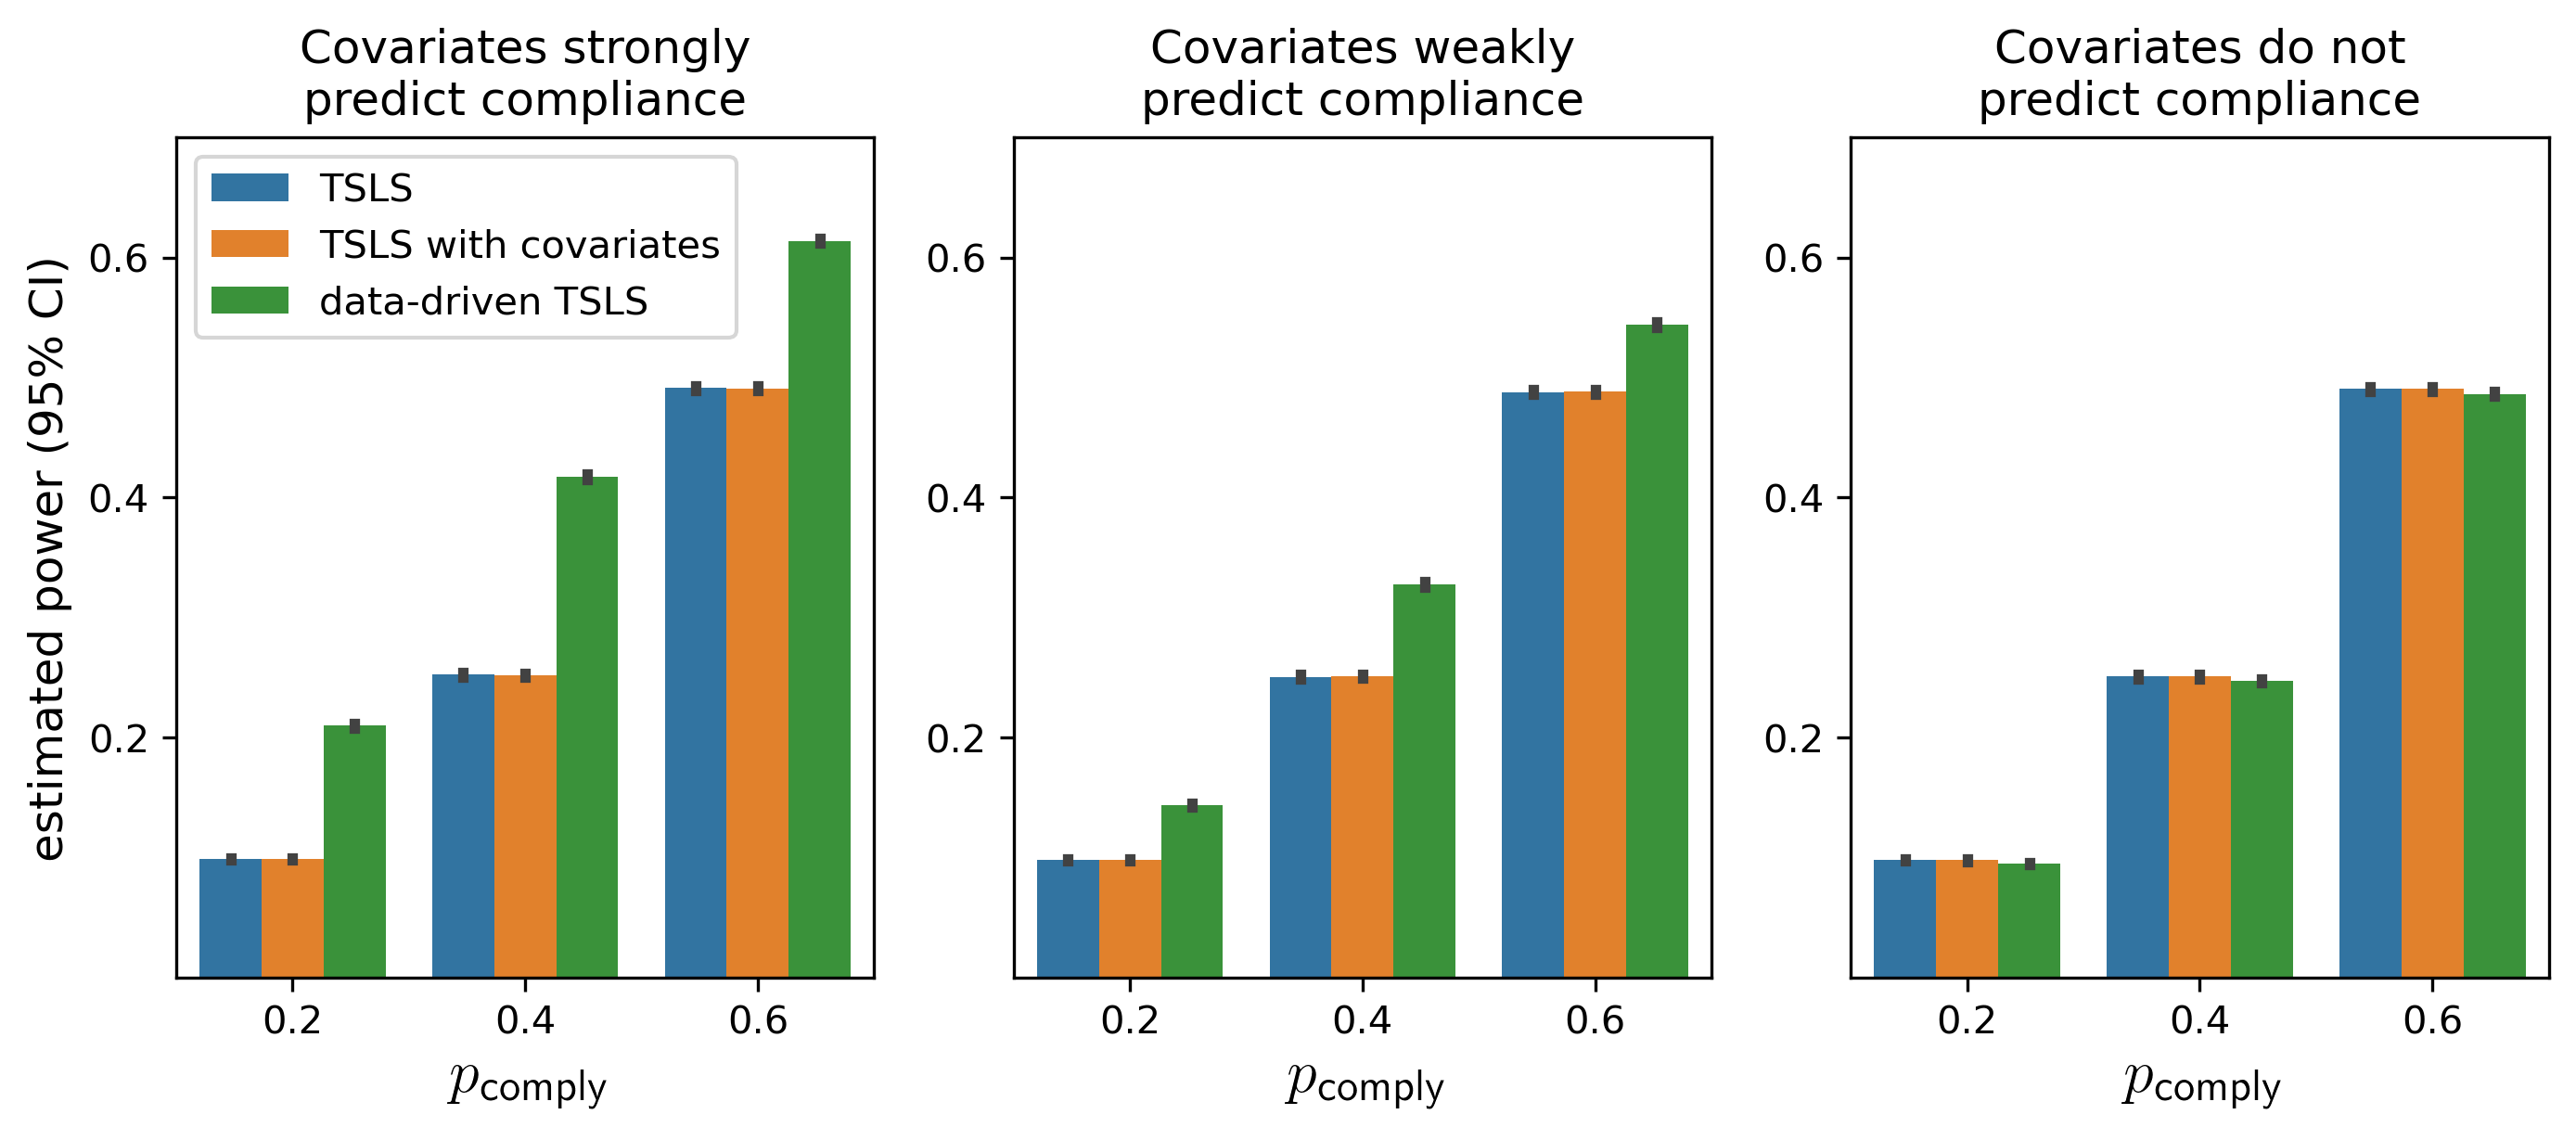

In [52]:
fig, pwr_axes = plt.subplots(1,3, figsize=(11,4), dpi=300)
x_var = 'Proportion compliers'

plt.rcParams.update({
    "text.usetex": False,
    'text.latex.preamble' : [r'\usepackage{amsmath}']
})

for idx, data_name in enumerate(['strong_comply', 'weak_comply', 'noise_comply']):
    
    cur_df = result_dict[data_name]
    
    tau_hats = pd.melt(cur_df, id_vars=[x_var], value_vars = ['tau_hat_full_simple', 'tau_hat_full_covar', 
                                                              'tau_hat_s1_s2_simple'])
    pwrs = pd.melt(cur_df, id_vars=[x_var], value_vars = ['pwr_full_simple', 'pwr_full_covar', 
                                                          'pwr_s1_s2_simple'])

    
    # pwr plotting
    sns.barplot(data=pwrs, hue="variable", x=x_var, y="value", ax=pwr_axes[idx])
    pwr_axes[idx].set_ylim(0,0.7)
    pwr_axes[idx].set_ylabel("")
    pwr_axes[idx].set_xlabel("")
    pwr_axes[idx].get_legend().remove()
    
#tau_axes[0].set_ylabel("est. treatment effect (95% CI)")
pwr_axes[0].set_ylabel("estimated power (95% CI)", fontsize=12)

pwr_axes[0].set_title("Covariates strongly\npredict compliance")
pwr_axes[1].set_title("Covariates weakly\npredict compliance")
pwr_axes[2].set_title("Covariates do not\npredict compliance")
#pwr_axes[1].set_xlabel("Proportion compliers\n\nCovariates weakly predict compliance")

pwr_axes[0].set_xlabel(r'$p_{\text{comply}}$', usetex=True, fontsize=16)
pwr_axes[1].set_xlabel(r'$p_{\text{comply}}$', usetex=True, fontsize=16)
pwr_axes[2].set_xlabel(r'$p_{\text{comply}}$', usetex=True, fontsize=16)

pwr_axes[0].set_yticks([0.2, 0.4, 0.6])
pwr_axes[1].set_yticks([0.2, 0.4, 0.6])
pwr_axes[2].set_yticks([0.2, 0.4, 0.6])

handles, labels = pwr_axes[0].get_legend_handles_labels()
new_labels = ['TSLS', 'TSLS with covariates', 'data-driven TSLS']
pwr_axes[0].legend(handles, new_labels)

#plt.savefig("../figures/data_driven_pwr.png", bbox_inches='tight', dpi=300)

## 3 plots: treatment

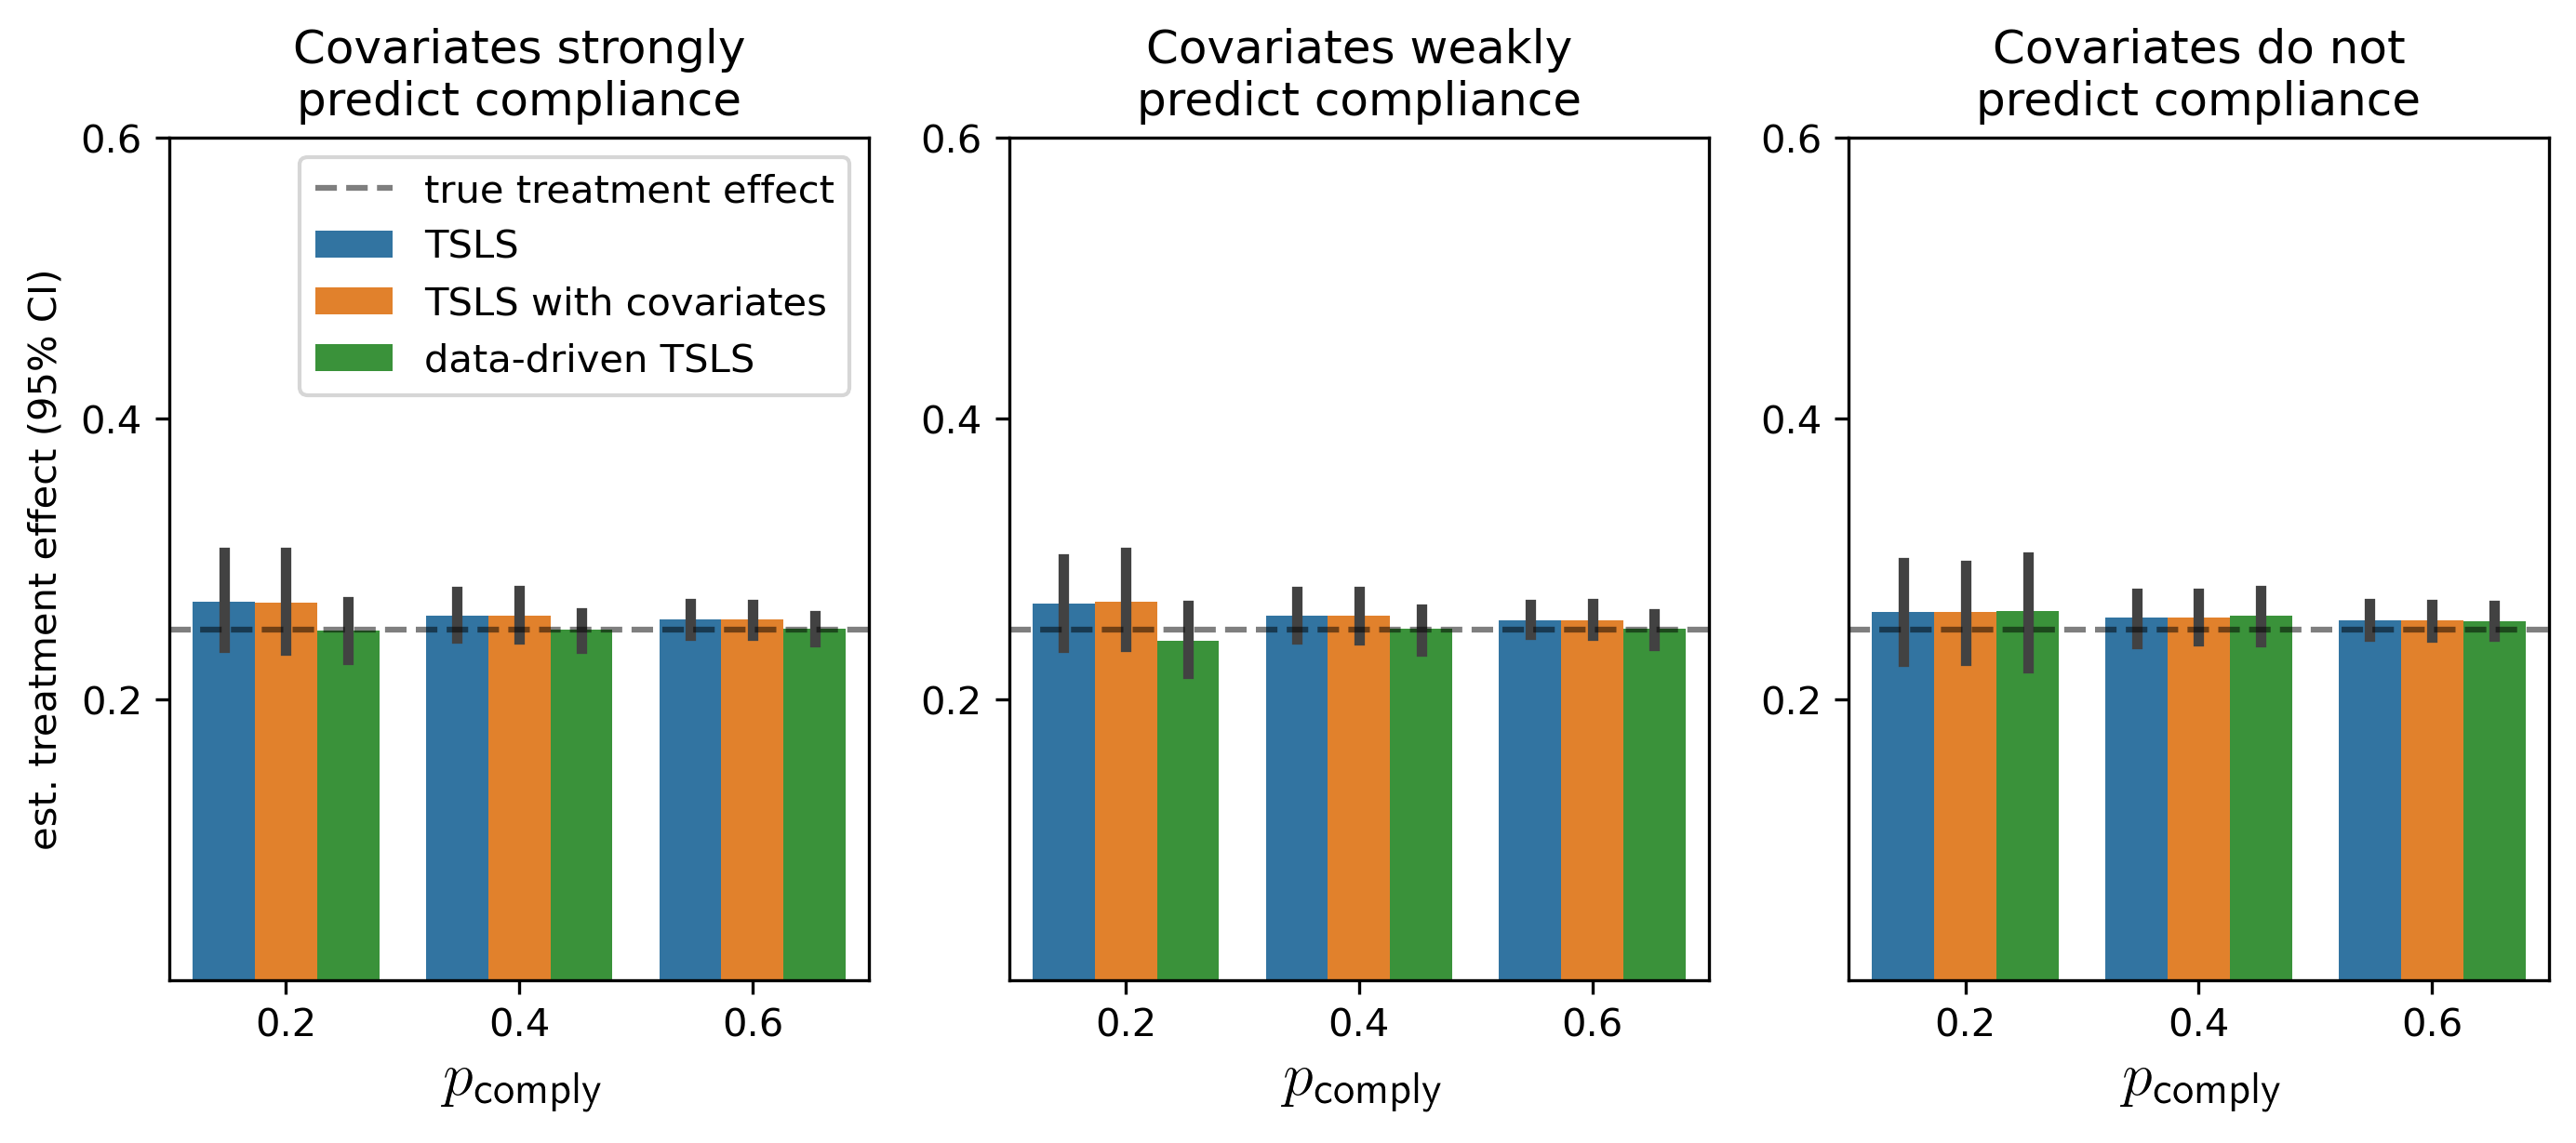

In [53]:
fig, tau_axes = plt.subplots(1,3, figsize=(11,4), dpi=300)
x_var = 'Proportion compliers'

plt.rcParams.update({
    "text.usetex": False,
    'text.latex.preamble' : [r'\usepackage{amsmath}']
})

for idx, data_name in enumerate(['strong_comply', 'weak_comply', 'noise_comply']):
    
    cur_df = result_dict[data_name]
    
    tau_hats = pd.melt(cur_df, id_vars=[x_var], value_vars = ['tau_hat_full_simple', 'tau_hat_full_covar', 
                                                              'tau_hat_s1_s2_simple'])
    pwrs = pd.melt(cur_df, id_vars=[x_var], value_vars = ['pwr_full_simple', 'pwr_full_covar', 
                                                          'pwr_s1_s2_simple'])

    #tau plotting
    sns.barplot(data=tau_hats, hue="variable", x=x_var, y="value", ax=tau_axes[idx])
    tau_axes[idx].axhline(y=tau, label="true treatment effect", ls='--', color="black", alpha=0.5)
    tau_axes[idx].set_ylim(0,0.5)
    tau_axes[idx].set_ylabel("")
    tau_axes[idx].set_xlabel("")
    if idx > 0:
        tau_axes[idx].get_legend().remove()
    
tau_axes[0].set_ylabel("est. treatment effect (95% CI)")
#tau_axes[0].set_ylabel("estimated power (95% CI)", fontsize=12)

tau_axes[0].set_title("Covariates strongly\npredict compliance")
tau_axes[1].set_title("Covariates weakly\npredict compliance")
tau_axes[2].set_title("Covariates do not\npredict compliance")
#tau_axes[1].set_xlabel("Proportion compliers\n\nCovariates weakly predict compliance")

tau_axes[0].set_xlabel(r'$p_{\text{comply}}$', usetex=True, fontsize=16)
tau_axes[1].set_xlabel(r'$p_{\text{comply}}$', usetex=True, fontsize=16)
tau_axes[2].set_xlabel(r'$p_{\text{comply}}$', usetex=True, fontsize=16)

tau_axes[0].set_yticks([0.2, 0.4, 0.6])
tau_axes[1].set_yticks([0.2, 0.4, 0.6])
tau_axes[2].set_yticks([0.2, 0.4, 0.6])

handles, labels = tau_axes[0].get_legend_handles_labels()
new_labels = ['true treatment effect', 'TSLS', 'TSLS with covariates', 'data-driven TSLS']
tau_axes[0].legend(handles, new_labels)


#plt.savefig("../figures/data_driven_tau.png", bbox_inches='tight', dpi=300)

## Simplified plot for presentation

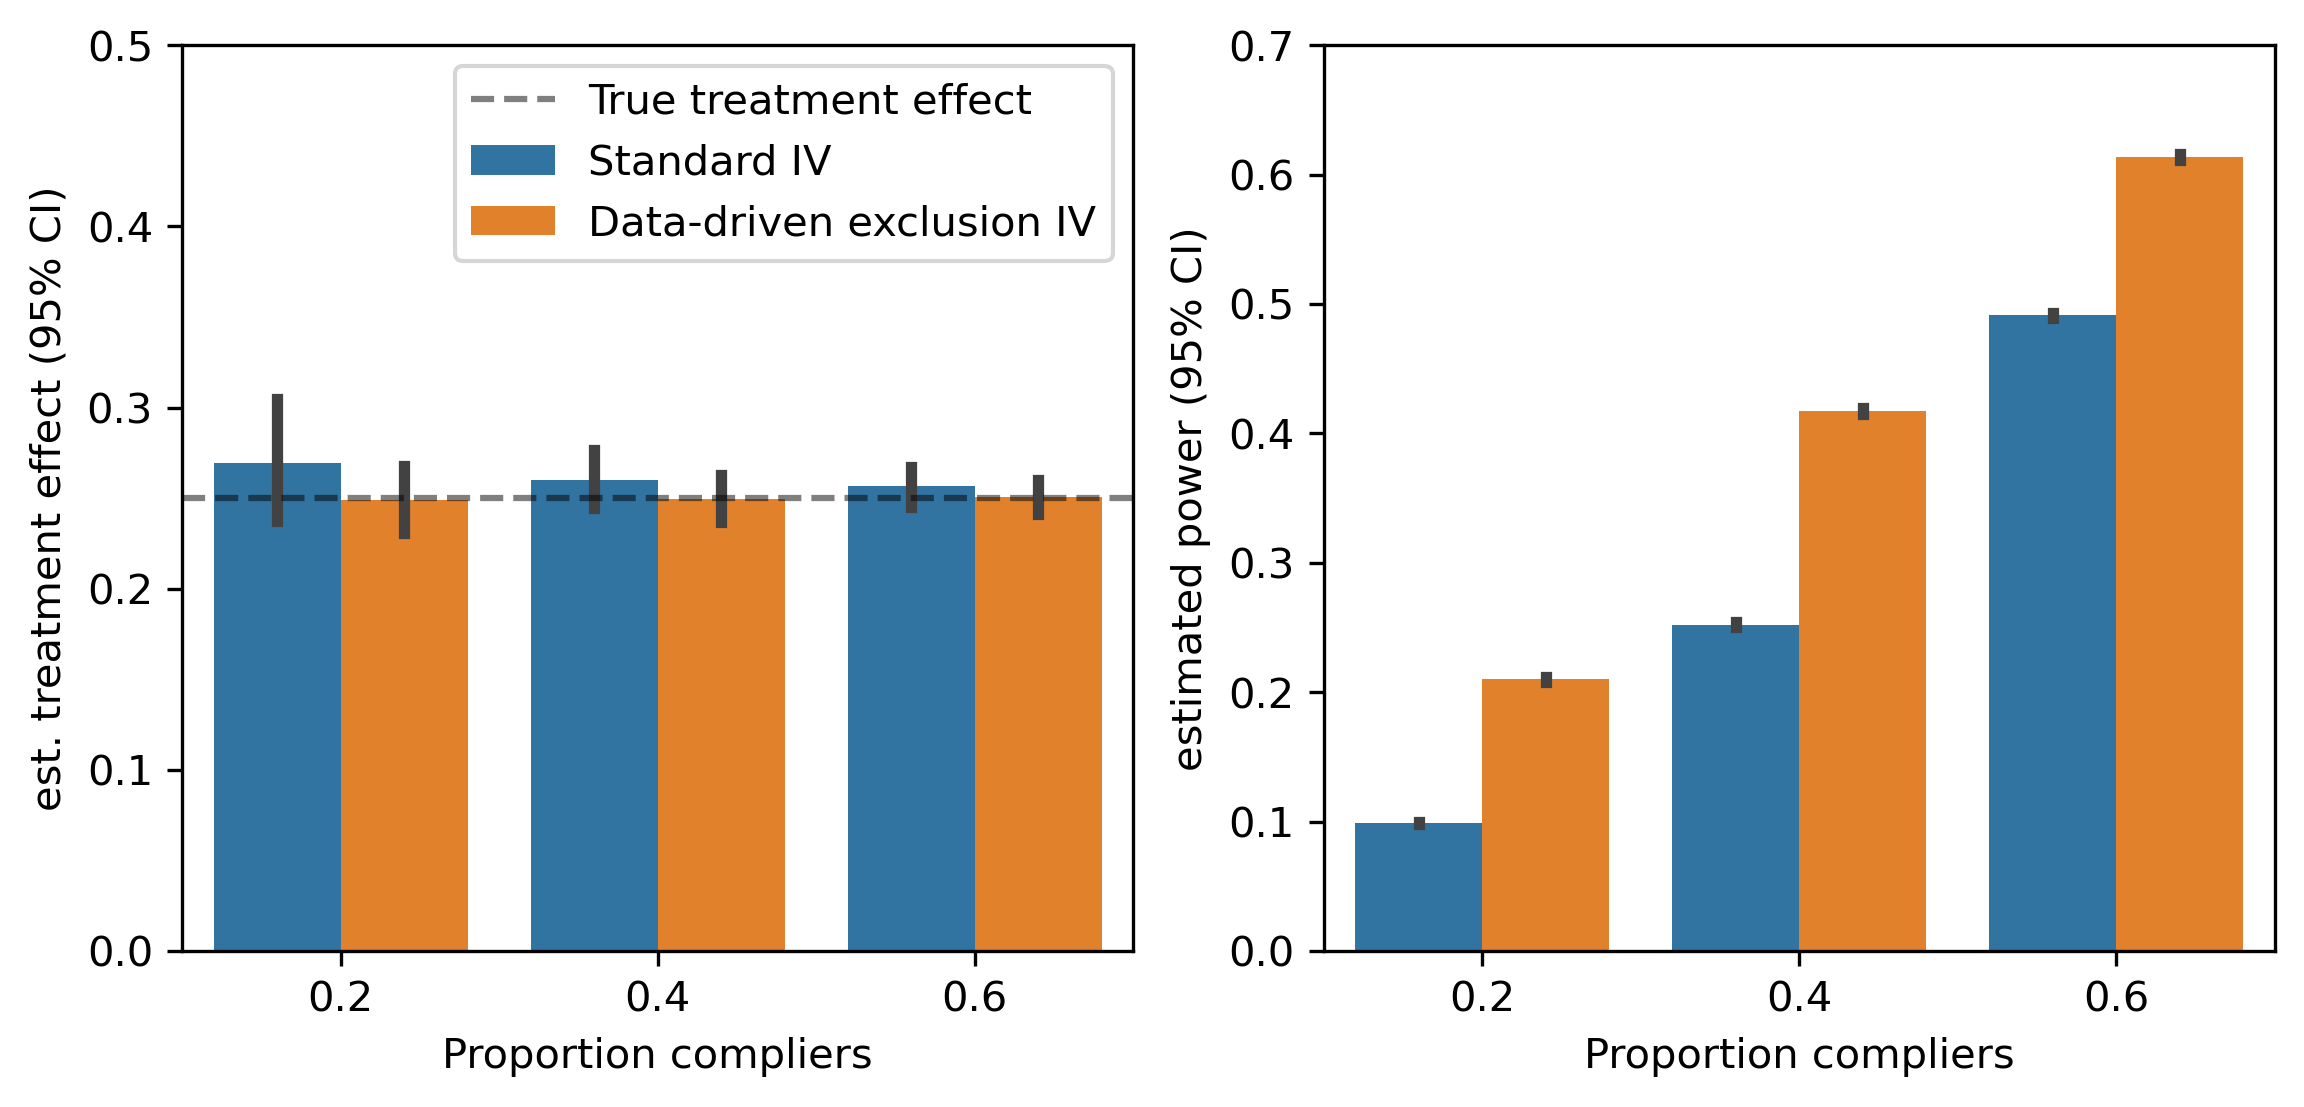

In [54]:
fig, (tau_ax, pwr_ax) = plt.subplots(1,2, figsize=(9,4), dpi=300)
x_var = 'Proportion compliers'

plt.rcParams.update({
    "text.usetex": False,
    'text.latex.preamble' : [r'\usepackage{amsmath}']
})



cur_df = result_dict['strong_comply']

tau_hats = pd.melt(cur_df, id_vars=[x_var], value_vars = ['tau_hat_full_simple',
                                                          'tau_hat_s1_s2_simple'])
pwrs = pd.melt(cur_df, id_vars=[x_var], value_vars = ['pwr_full_simple',
                                                      'pwr_s1_s2_simple'])

# tau plotting
sns.barplot(data=tau_hats, hue="variable", x=x_var, y="value", ax=tau_ax)
tau_ax.axhline(y=tau, label="true treatment effect", ls='--', color="black", alpha=0.5)
tau_ax.set_ylim(0,0.5)
tau_ax.set_ylabel("")
tau_ax.set_xlabel("Proportion compliers")

# pwr plotting
sns.barplot(data=pwrs, hue="variable", x=x_var, y="value", ax=pwr_ax)
pwr_ax.set_ylim(0,0.7)
pwr_ax.set_ylabel("")
pwr_ax.set_xlabel("Proportion compliers")
pwr_ax.get_legend().remove()
    
tau_ax.set_ylabel("est. treatment effect (95% CI)")
pwr_ax.set_ylabel("estimated power (95% CI)")

#pwr_axes[0].set_title("Covariates strongly predict compliance")
#pwr_axes[1].set_title("Covariates weakly predict compliance")
#pwr_axes[2].set_title("Covariates do not predict compliance")
#pwr_axes[1].set_xlabel("Proportion compliers\n\nCovariates weakly predict compliance")

#pwr_axes[0].set_xlabel(r'$p_{\text{comply}}$', usetex=True)
#pwr_axes[1].set_xlabel(r'$p_{\text{comply}}$', usetex=True)
#pwr_axes[2].set_xlabel(r'$p_{\text{comply}}$', usetex=True)


handles, labels = tau_ax.get_legend_handles_labels()
new_labels = ['True treatment effect', 'Standard IV', 'Data-driven exclusion IV']
tau_ax.legend(handles, new_labels)
